VAE　オートエンコーダー

参考文献　我妻幸長　「はじめてのディープラーニング２」

In [1]:
#　colaboraory用: Google drive をマウントする
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# colaboratory用: フォルダを移る
%cd "drive/My Drive/Colab Notebooks"

/content/drive/My Drive/Colab Notebooks


フォルダは自分の指定のものに変更して下さい。

In [3]:
%cd "ctorch210929/MiniCTorch_Prototype/notebook"

/content/drive/My Drive/Colab Notebooks/ctorch210929/MiniCTorch_Prototype/notebook


In [4]:
! pip install lark-parser

In [5]:
import sys
sys.path.append("../")

import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import minictorch.generator as GN
import minictorch.converter as CV

サンプルデータ

In [6]:
import torch.utils as utils
from torchvision import datasets, transforms
from sklearn import datasets

img_size = 8
n_in = img_size * img_size
n_mid = 16
n_out = n_in
n_z = 2
n_batch = 32

digits_data = datasets.load_digits()
dd = np.asarray( digits_data.data, dtype=np.float32 )
dd /= 15
x_train = torch.from_numpy( dd ).clone()
t_train = digits_data.target
print(len(x_train))

1797


サンプルデータの図化

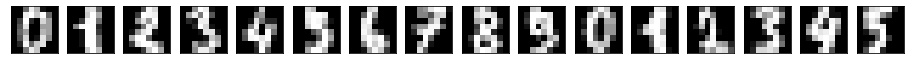

In [7]:
import matplotlib.pyplot as plt
n_img = 16

plt.figure( figsize=(16,3))
for i in range(n_img):
  ax = plt.subplot(3,n_img,i+1)
  plt.imshow(dd[i].reshape(img_size,-1).tolist(),cmap="Greys_r")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

ニューラルネットワークの定義

In [13]:
def mean_squared_error( x0, x1 ):
    diff = x0 - x1
    y = (diff**2).sum() / len(diff)
    return y;

def reconstruction( y, t ):
  eps = 1.0e-7
  e = t * torch.log(y+eps) + (1-t) * torch.log(1-y+eps) 
  z = e.sum() / len(y)
  return z;

def kl_divergence( mean, log_var ):
  g = 1 + log_var - mean**2 - torch.exp( log_var )
  y = 0.5 * g.sum() / len(mean)
  return y

import torch.distributions as tdist

class Net(torch.nn.Module):
  def __init__( self, n_in, n_mid, n_out, n_z, e ):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_in, n_mid)
    #self.bn1 = nn.BatchNorm1d(n_mid)
    self.fc2_mean = nn.Linear(n_mid, n_z)
    self.fc2_var  = nn.Linear(n_mid, n_z)
    self.fc3 = nn.Linear(n_z  ,n_mid)
    self.fc4 = nn.Linear(n_mid,n_out)
    #self.drop1 = nn.Dropout(p=0.2)
    self.eps = e

    nn.init.constant_(self.fc1.bias,0)
    nn.init.constant_(self.fc2_mean.bias,0)
    nn.init.constant_(self.fc2_var.bias,0)
    nn.init.constant_(self.fc3.bias,0)
    nn.init.constant_(self.fc4.bias,0)
  
  def forward( self, x ):
    # encoder
    self.x2 = F.relu( self.fc1(x) )
    #self.x2 = self.bn1( self.x1 )
    self.mean    = self.fc2_mean( self.x2 )
    self.log_var = self.fc2_var( self.x2 )

    # reparametrization
    #eps = torch.randn( n_batch, n_z )
    eps = torch.randn( self.mean.shape )
    #nm = tdist.Normal( 0.0, 1.0 ) #torch.tensor([0.0]), torch.tensor([1.0]))
    #eps = nm.sample([ n_batch, n_z ])
    #eps = torch.normal(0.0,1.0,[32,2])
    #print("eps",eps)
    self.z = self.mean + eps * torch.exp( 0.5 * self.log_var )
    #self.z = self.mean + self.eps * torch.exp( 0.5 * self.log_var )

    # decoder
    self.y1 = F.relu( self.fc3( self.z ) )
    #self.y2 = self.drop1( self.y1)
    y = torch.sigmoid( self.fc4( self.y1 ) )
    self.out = y 
    
    e1 = reconstruction( y, x )
    e2 = kl_divergence( self.mean, self.log_var )
    return -(e1+e2)

In [14]:
def generate_json( json_path, input, e ):

    model = Net( n_in, n_mid, n_out, n_z, e )

    model.eval()
    with torch.no_grad():
        print("[SAVE]", json_path )
        GN.generate_minictorch_file( model, input, json_path )

    return model

In [19]:
torch.manual_seed( 1 )

project = 'vae1'
json_path = '../network/' + project +'.json'

x = x_train.clone().detach()
torch.reshape( x, (-1,n_in) )

x = x[0:n_batch,:]
#print(type(x))
#print(x.shape)
x.requires_grad = True

e = torch.randn( n_batch, 2 )
print("eps",e)

model = generate_json( json_path, x, e )

with torch.set_grad_enabled(True):
  model.eval()
  output = model( x )
  print("output",output)
  output.backward()
  print("input_grad",x.grad)

eps tensor([[-1.5256, -0.7502],
        [-0.6540, -1.6095],
        [-0.1002, -0.6092],
        [-0.9798, -1.6091],
        [-0.7121,  0.3037],
        [-0.7773, -0.2515],
        [-0.2223,  1.6871],
        [ 0.2284,  0.4676],
        [-0.6970, -1.1608],
        [ 0.6995,  0.1991],
        [ 0.8657,  0.2444],
        [-0.6629,  0.8073],
        [ 1.1017, -0.1759],
        [-2.2456, -1.4465],
        [ 0.0612, -0.6177],
        [-0.7981, -0.1316],
        [ 1.8793, -0.0721],
        [ 0.1578, -0.7735],
        [ 0.1991,  0.0457],
        [ 0.1530, -0.4757],
        [-0.1110,  0.2927],
        [-0.1578, -0.0288],
        [ 2.3571, -1.0373],
        [ 1.5748, -0.6298],
        [-0.9274,  0.5451],
        [ 0.0663, -0.4370],
        [ 0.7626,  0.4415],
        [ 1.1651,  2.0154],
        [ 0.1374,  0.9386],
        [-0.1860, -0.6446],
        [ 1.5392, -0.8696],
        [-3.3312, -0.7479]])
[SAVE] ../network/vae1.json
skip: Net/Linear[fc1]/weight/117
skip: Net/Linear[fc1]/weight/117
skip:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TracerWarning: Using len to get tensor shape might cause the trace to be incorrect. Recommended usage would be tensor.shape[0]. Passing a tensor of different shape might lead to errors or silently give incorrect results.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: TracerWarning: Using len to get tensor shape might cause the trace to be incorrect. Recommended usage would be tensor.shape[0]. Passing a tensor of different shape might lead to errors or silently give incorrect results.
  
/usr/local/lib/python3.7/dist-packages/torch/jit/_trace.py:985: TracerWarning: Trace had nondeterministic nodes. Did you forget call .eval() on your model? Nodes:
	%eps : Float(32, 2, strides=[2, 1], requires_grad=0, device=cpu) = aten::randn(%41, %42, %43, %44, %45) # <ipython-input-13-8f9dd27cbeb0>:46:0
This may cause errors in trace checking. To disable trace checking, pass check_trace=False

In [ ]:
"""
def convert_json( project, folder, model, input_x, json_path, rand_flag=0 ):

    #folder = "src"
    cpp_fname   = project + ".cpp"
    param_fname = project + "_param.cpp"
    cpp_path    = folder + "/" + cpp_fname
    param_path  = folder + "/" + param_fname
    make_path   = folder + "/" + "Makefile"

    # load json file
    print( "[JSON]", json_path )
    fp = open( json_path )
    obj = json.load( fp )

    # save parameter file
    code1 = CV.c_param_generator( obj, model, input_x )
    if len( code1 ) > 0:
       print( "[PARAM]", param_path )
       ofparam = open( param_path, "w" )
       ofparam.write( code1 )

    # save cpp file
    print( "[CPP]  ", cpp_path )
    code2 = CV.c_code_generator( obj, model, rand_flag )

    #ofp=open(args.path+"/"+args.output,"w")
    ofp = open( cpp_path, "w" )
    ofp.write( code2 )

    # save make file
    print( "[MAKE] ", make_path )
    make_code = CV.makefile_generator( cpp_fname )

    #makefp=open(args.path+"/"+"Makefile","w")
    makefp = open( make_path, "w" )
    makefp.write( make_code )

convert_json( project, "src", model, x, json_path )
"""

In [20]:
CV.convert_json( project, "../src", model, x, json_path )

[JSON] ../network/vae1.json
{'name': 'Net/Linear[fc1]/weight/141', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [3], 'sorted_id': 1}
{'name': 'Net/Linear[fc1]/bias/140', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [3], 'sorted_id': 2}
{'name': 'Net/Linear[fc2_mean]/weight/144', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [7], 'sorted_id': 5}
{'name': 'Net/Linear[fc2_mean]/bias/143', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [7], 'sorted_id': 6}
{'name': 'Net/Linear[fc2_var]/weight/147', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [24], 'sorted_id': 22}
{'name': 'Net/Linear[fc2_var]/bias/146', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [24], 'sorted_id': 23}
{'name': 'Net/Linear[fc3]/weight/150', 'op': 'prim::GetAttr', 'in': [], 'output_id': 0, 'shape': [], 'out': [33], 'sorted_id': 31}
{'name': 'Net/Linear[fc3]/bias/149', 'op': 'prim::G

In [21]:
!g++ -std=c++14 ../src/vae1.cpp ../src/vae1_param.cpp -I ../../../xtensor -lcblas -o ../bin/vae1

(注意) xtensorにxtensor関連のincludeを置いています。各自の環境に合わせて変更して下さい。

In [22]:
!../bin/vae1

### forward computation ...
{ 44.494682}
### backward computation ...
input_grad{{-0.002586, -0.001948, -0.000243, ...,  0.000267, -0.001652,  0.000374},
 {-0.000897, -0.001041, -0.000241, ...,  0.000115, -0.00004 ,  0.000886},
 {-0.007821, -0.006974,  0.000222, ...,  0.001697, -0.003437,  0.003318},
 ..., 
 { 0.000084, -0.000341, -0.000042, ..., -0.000469, -0.000338,  0.000462},
 {-0.002681,  0.000023,  0.000841, ...,  0.001294,  0.000238,  0.002403},
 {-0.003409, -0.000474,  0.001231, ...,  0.001605, -0.000005,  0.005013}}


最適化実行

全入力データを vae1_data.cpp に出力する

In [24]:
def output_datafile( folder, project, in_data ):
    data_fname = project + "_data.cpp"
    data_path  = folder + "/" + data_fname

    # save data file
    code = CV.c_data_generator( in_data )
    if len( code ) > 0:
       print( "[DATA]", data_path )
       ofparam = open( data_path, "w" )
       ofparam.write( code )

output_datafile( "../src", project, dd )

param: indata  - str loop  5000  /  14375
param: indata  - str loop  10000  /  14375
[DATA] ../src/vae1_data.cpp


In [51]:
!g++ -std=c++14 ../src/vae1.cpp ../src/vae1_param.cpp ../src/vae1_data.cpp ../src/vae1_train.cpp  -I ../../../xtensor -lcblas -o ../bin/vae1_train

In [52]:
!../bin/vae1_train

batch1 1797,64
batch2 56,32
epoch_num : 200
total_loss 0 loss - 2252.21
epoch 0 - loss { 33.315163}
total_loss 1 loss - 1722.82
epoch 1 - loss { 29.588337}
total_loss 2 loss - 1636.86
epoch 2 - loss { 28.864582}
total_loss 3 loss - 1608.91
epoch 3 - loss { 28.606874}
total_loss 4 loss - 1596.23
epoch 4 - loss { 28.399221}
total_loss 5 loss - 1585.78
epoch 5 - loss { 28.196524}
total_loss 6 loss - 1577.11
epoch 6 - loss { 28.112505}
total_loss 7 loss - 1569.49
epoch 7 - loss { 27.971659}
total_loss 8 loss - 1561.71
epoch 8 - loss { 27.893692}
total_loss 9 loss - 1558.49
epoch 9 - loss { 27.743196}
total_loss 10 loss - 1550.25
epoch 10 - loss { 27.667103}
total_loss 11 loss - 1542.64
epoch 11 - loss { 27.463993}
total_loss 12 loss - 1531.02
epoch 12 - loss { 27.312462}
total_loss 13 loss - 1523.03
epoch 13 - loss { 27.131021}
total_loss 14 loss - 1516.12
epoch 14 - loss { 26.99172 }
total_loss 15 loss - 1509.93
epoch 15 - loss { 26.916931}
total_loss 16 loss - 1504.78
epoch 16 - loss { 2

c++ からの出力ファイルの読み込み

In [53]:
#load out file
f = open('./vae1.out', 'r')

epoch_loss = []
datalist = f.readlines()
for data in datalist:
  #print(data)
  epoch_loss.append( float(data) )

f.close()

print("epoch =", len(epoch_loss))
print( epoch_loss)

# load pred file
f2 = open('vae1.pred', 'r')

datalist = f2.readlines()

n1 = 10
n2 = 64
k = 0
for data in datalist:
  ds = data.split(',')
  if k==0:
    n1 = int(ds[0])
    n2 = int(ds[1])
    global v_pred
    v_pred = np.zeros( (n1,n2))
  else:
    for i in range(n2):
      v_pred[k-1,i] = float(ds[i])
  k = k+1

f2.close()

print("pred =", n1,n2 )
#print( y_pred )

# load z file
f3 = open('vae1.z', 'r')

datalist = f3.readlines()
n1 = 100
n2 = 2
k = 0
for data in datalist:
  ds = data.split(',')
  if k==0:
    nz1 = int(ds[0])
    nz2 = int(ds[1])
    z_pred = np.zeros( (nz1,nz2))
  else:
    z_pred[k-1,0] = float(ds[0])
    z_pred[k-1,1] = float(ds[1])
  k = k+1

f3.close()

print("z =", nz1,nz2 )
#print(z_pred)

epoch = 200
[33.315163, 29.588337, 28.864582, 28.606874, 28.399221, 28.196524, 28.112505, 27.971659, 27.893692, 27.743196, 27.667103, 27.463993, 27.312462, 27.131021, 26.99172, 26.916931, 26.820824, 26.766123, 26.719816, 26.643881, 26.562258, 26.530367, 26.381763, 26.348427, 26.247, 26.206259, 26.074146, 26.01207, 25.915354, 25.825445, 25.789684, 25.732431, 25.681158, 25.596584, 25.599388, 25.504528, 25.552197, 25.476049, 25.487141, 25.430086, 25.386909, 25.368185, 25.42617, 25.372347, 25.319706, 25.36867, 25.2885, 25.297209, 25.240147, 25.268906, 25.26305, 25.249092, 25.24477, 25.199209, 25.200945, 25.177311, 25.178785, 25.208733, 25.133114, 25.14896, 25.134329, 25.100973, 25.088497, 25.069168, 25.01796, 25.07704, 24.987013, 24.995789, 24.962414, 24.969923, 24.969856, 24.9928, 25.016535, 24.978628, 24.912752, 24.906364, 24.89068, 25.001881, 24.921247, 24.864115, 24.793262, 24.843006, 24.793827, 24.725113, 24.733711, 24.677113, 24.653231, 24.744532, 24.675917, 24.748131, 24.660444, 24.

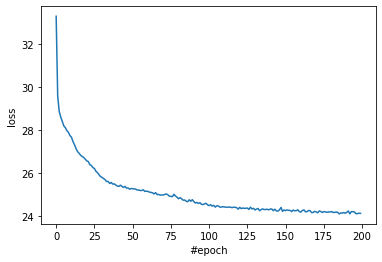

In [54]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(epoch_loss))), epoch_loss)
ax.set_xlabel('#epoch')
ax.set_ylabel('loss')
fig.show()

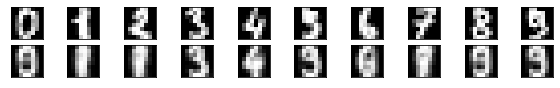

In [55]:
n_img5 = 10
x2 = x[:n_img5]

plt.figure( figsize=(10,2))
for i in range(n_img5):
  # input image
  ax = plt.subplot(3,n_img5,i+1)
  plt.imshow( x2[i].reshape(img_size,-1).tolist(),cmap="Greys_r")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # output image
  ax = plt.subplot(3,n_img5,i+1+n_img5)
  plt.imshow( v_pred[i].reshape(img_size,-1).tolist(),cmap="Greys_r")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

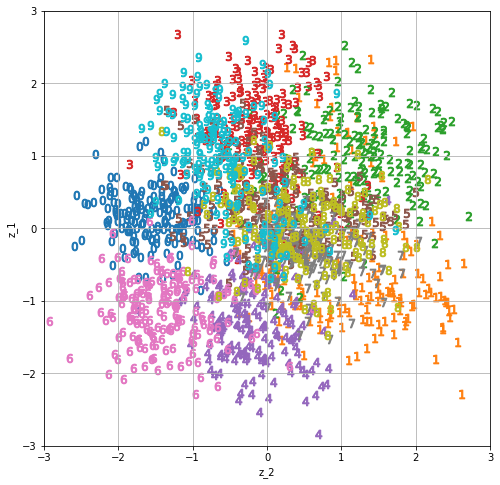

In [56]:
t2 = t_train #[:n_batch]

plt.figure(figsize=(8,8))
for i in range(10):
  zt = z_pred[t2==i]
  z_1 = zt[:,0]
  z_2 = zt[:,1]
  marker= "$"+str(i)+"$"
  plt.scatter( z_2.tolist(),  z_1.tolist(), marker=marker,s=75 )

plt.xlabel("z_2")
plt.ylabel("z_1")
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.grid()
plt.show()

In [ ]:
# yet

n_img3=16
img_size_spaced = img_size + 2
matrix_image = np.zeros(( img_size_spaced*n_img3, img_size_spaced*n_img3 ))

z_1 = np.linspace( 3, -3, n_img3 )
z_2 = np.linspace( 3, -3, n_img3 )

with torch.set_grad_enabled(False):
  for i, z1 in enumerate(z_1):
    for j,z2 in enumerate(z_2):

      z = np.array([z1, z2])
      zz = torch.from_numpy( z ).float()
      
      y = F.relu( net.fc3(zz) )
      o = torch.sigmoid( net.fc4(y) )
      image = o.reshape(img_size, img_size)
      top  = i * img_size_spaced
      left = j * img_size_spaced
      matrix_image[top:top+img_size, left:left+img_size] = image

plt.figure(figsize=(8,8))
plt.imshow( matrix_image.tolist(), cmap="Greys_r" )
plt.tick_params( labelbottom=False, labelleft=False, bottom=False, left=False )
plt.show()